In [87]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, PowerTransformer, QuantileTransformer, StandardScaler
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.feature_selection import RFECV, RFE, SelectKBest, f_regression
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
import seaborn as sns
from matplotlib import pyplot as plt

In [88]:
one_hot_encoder = OneHotEncoder(handle_unknown='ignore')
min_max_scaler = MinMaxScaler()
standar_scaler = StandardScaler()
bc = PowerTransformer(method="box-cox")
yj = PowerTransformer(method="yeo-johnson")
rng = np.random.RandomState(304)
qt = QuantileTransformer(n_quantiles=500, output_distribution="normal", random_state=rng)

In [89]:
def graficar_info_variable(variable, b=8):
    _, axes = plt.subplots(1, 3, figsize=(15, 5))
    sns.histplot(data=variable, bins=b ,ax=axes[0])
    sns.boxplot(data=variable, ax=axes[1])
    sns.violinplot(data=variable, ax=axes[2])

def porcentaje_outliers(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    BI = Q1 - 1.5*IQR
    BS = Q3 + 1.5*IQR
    out = ((data < BI) | (data > BS))
    print("Porcentaje de outliers: ", 100*out.sum()/out.count())

def quitar_outliers(data, df_feature):
    Q1 = df_feature.quantile(0.25)
    Q3 = df_feature.quantile(0.75)
    IQR = Q3 - Q1
    BI = Q1 - 1.5*IQR
    BS = Q3 + 1.5*IQR
    out = ((df_feature > BI) & (df_feature < BS))
    data = data.loc[out]
    return data

In [90]:
df = pd.read_csv('ToyotaCorolla_modificado - ToyotaCorolla_modificado.csv')
df.head()

,Id,Model,Price,Age_08_04,Mfg_Month,Mfg_Year,KM,Fuel_Type,HP,Met_Color,...,Central_Lock,Powered_Windows,Power_Steering,Radio,Mistlamps,Sport_Model,Backseat_Divider,Metallic_Rim,Radio_cassette,Tow_Bar
0,1,TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors,13500,23,10,2002,46986,Diesel,90,1,...,1,1,1,0,0,0,1,0,0,0
1,2,TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors,13750,23,10,2002,72937,Diesel,90,1,...,1,0,1,0,0,0,1,0,0,0
2,3,?TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors,13950,24,9,2002,41711,Diesel,90,1,...,0,0,1,0,0,0,1,0,0,0
3,4,TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors,14950,26,7,2002,48000,Diesel,90,0,...,0,0,1,0,0,0,1,0,0,0
4,5,TOYOTA Corolla 2.0 D4D HATCHB SOL 2/3-Doors,13750,30,3,2002,38500,Diesel,90,0,...,1,1,1,0,1,0,1,0,0,0


In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1436 entries, 0 to 1435
Data columns (total 37 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Id                1436 non-null   int64 
 1   Model             1436 non-null   object
 2   Price             1436 non-null   int64 
 3   Age_08_04         1436 non-null   int64 
 4   Mfg_Month         1436 non-null   int64 
 5   Mfg_Year          1436 non-null   int64 
 6   KM                1436 non-null   int64 
 7   Fuel_Type         1436 non-null   object
 8   HP                1436 non-null   int64 
 9   Met_Color         1436 non-null   int64 
 10  Automatic         1436 non-null   int64 
 11  cc                1436 non-null   int64 
 12  Doors             1436 non-null   int64 
 13  Cylinders         1436 non-null   int64 
 14  Gears             1436 non-null   int64 
 15  Quarterly_Tax     1436 non-null   int64 
 16  Weight            1436 non-null   int64 
 17  Mfr_Guarantee 

In [92]:
df.describe()

,Id,Price,Age_08_04,Mfg_Month,Mfg_Year,KM,HP,Met_Color,Automatic,cc,...,Central_Lock,Powered_Windows,Power_Steering,Radio,Mistlamps,Sport_Model,Backseat_Divider,Metallic_Rim,Radio_cassette,Tow_Bar
count,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.00000,...,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000,1436.000000
mean,721.555014,10730.824513,55.947075,5.548747,1999.625348,68533.259749,101.502089,0.674791,0.055710,1576.85585,...,0.580084,0.561978,0.977716,0.146240,0.256964,0.300139,0.770195,0.204735,0.145543,0.277855
std,416.476890,3626.964585,18.599988,3.354085,1.540722,37506.448872,14.981080,0.468616,0.229441,424.38677,...,0.493717,0.496317,0.147657,0.353469,0.437111,0.458478,0.420854,0.403649,0.352770,0.448098
min,1.000000,4350.000000,1.000000,1.000000,1998.000000,1.000000,69.000000,0.000000,0.000000,1300.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,361.750000,8450.000000,44.000000,3.000000,1998.000000,43000.000000,90.000000,0.000000,0.000000,1400.00000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,721.500000,9900.000000,61.000000,5.000000,1999.000000,63389.500000,110.000000,1.000000,0.000000,1600.00000,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,1081.250000,11950.000000,70.000000,8.000000,2001.000000,87020.750000,110.000000,1.000000,0.000000,1600.00000,...,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000
max,1442.000000,32500.000000,80.000000,12.000000,2004.000000,243000.000000,192.000000,1.000000,1.000000,16000.00000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [93]:
#Eliminar signo de interrogación de modelo y calcular valores únicos
df.Model = df.Model.apply(lambda x: x.replace('?', ''))
print("Valores únicos de modelos: ",len(df.Model.value_counts()))

Valores únicos de modelos:  319


In [94]:
#Encoder Fuel Type
fuel_encoder = one_hot_encoder.fit(df.Fuel_Type.values.reshape(-1, 1))
name_fuel = fuel_encoder.categories_[0]
fuel_encoder = fuel_encoder.transform(df.Fuel_Type.values.reshape(-1, 1))
fuel_type_encoder = pd.DataFrame(fuel_encoder.toarray(), columns=name_fuel)
df = df.drop(columns=['Fuel_Type'])
df = pd.concat([df, fuel_type_encoder], axis=1)

In [95]:
drop_columns = ['Model', 'Id', 'Cylinders']

In [96]:
df = df.drop(columns=drop_columns)

#### Definir x e y

In [97]:
y = df.Price
x = df.drop(columns=['Price'])
names=pd.DataFrame(x.columns)

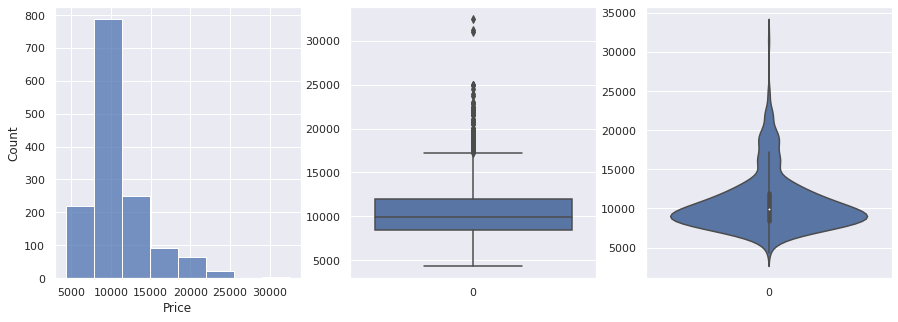

In [98]:
#Si modifico la variable price
graficar_info_variable(df.Price)

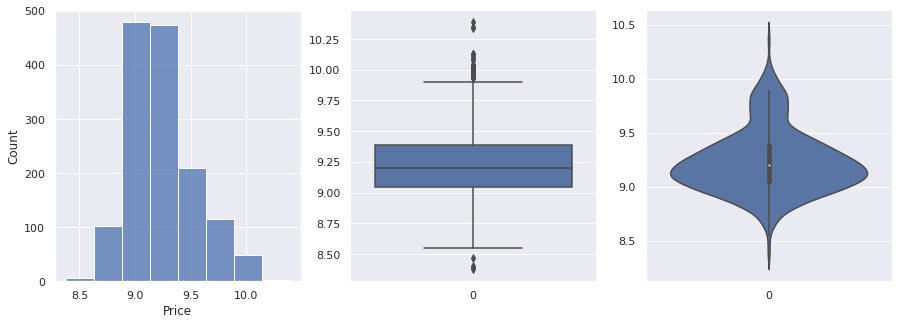

In [99]:
df.Price = np.log(df.Price)
graficar_info_variable(df.Price)

In [100]:
porcentaje_outliers(df.Price)

Porcentaje de outliers:  2.8551532033426184


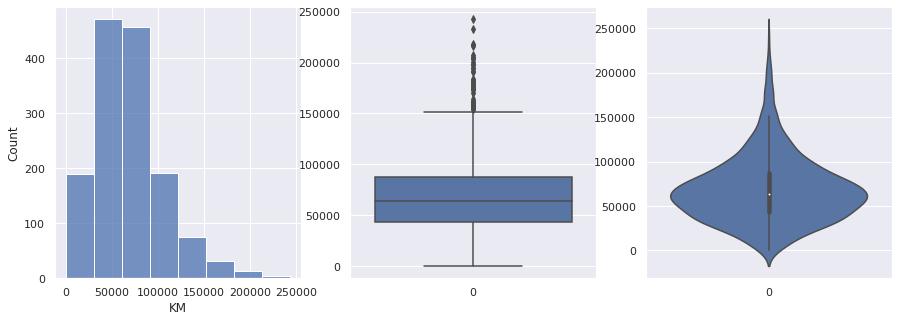

In [101]:
graficar_info_variable(df.KM)

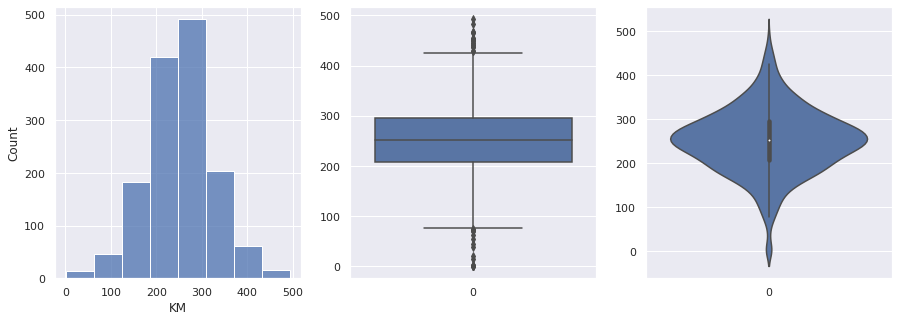

In [102]:
df.KM = np.sqrt(df.KM)
graficar_info_variable(df.KM)

In [103]:
porcentaje_outliers(df.KM)

Porcentaje de outliers:  2.6462395543175488


In [104]:
df = quitar_outliers(df, df.KM)
porcentaje_outliers(df.KM)

Porcentaje de outliers:  0.7153075822603719


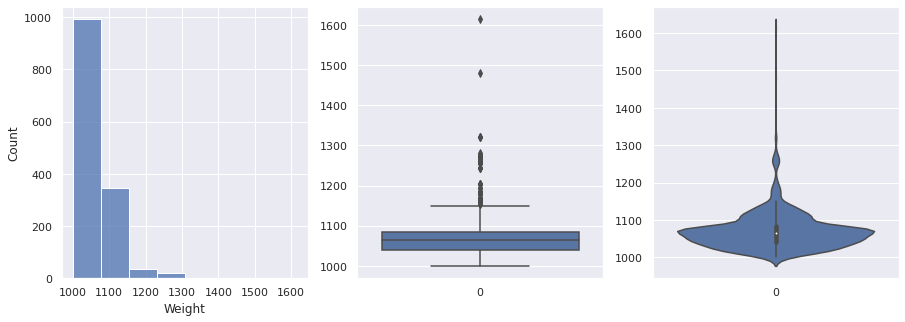

In [105]:
graficar_info_variable(df.Weight)

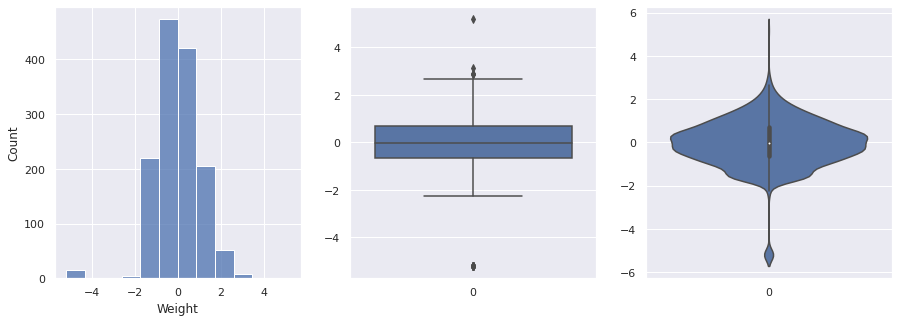

In [106]:
df.Weight = qt.fit_transform(df.Weight.values.reshape(-1, 1))
graficar_info_variable(df.Weight, 12)

In [107]:
porcentaje_outliers(df.Weight)

Porcentaje de outliers:  1.502145922746781


In [108]:
df = quitar_outliers(df, df.Weight)
porcentaje_outliers(df.Weight)

Porcentaje de outliers:  0.0


#### Univariate Feature Selection

In [68]:
m = SelectKBest(score_func=f_regression, k=4)
r = m.fit(x, y)
results_df=pd.DataFrame(r.scores_)
scored=pd.concat([names,results_df], axis=1)
scored.columns = ["Feature", "Score"]
scored.sort_values(by=['Score'])

,Feature,Score
1,Mfg_Month,0.471934
13,BOVAG_Guarantee,1.135864
6,Automatic,1.570992
34,Petrol,2.130519
32,CNG,2.245020
25,Radio,2.520447
30,Radio_cassette,2.678580
33,Diesel,4.206904
9,Gears,5.733157
24,Power_Steering,5.948894


In [109]:
columns = ['Mfg_Year', 'Age_08_04', 'Boardcomputer','Automatic_airco', 'Weight', 'KM', 'CD_Player', 'Airco', 'Powered_Windows',
           'Central_Lock', 'HP', 'ABS', 'Price']

In [110]:
df = df[columns]

In [111]:
y = df.Price.values.reshape(-1, 1)
x = df.drop(columns=['Price'])

In [112]:
x.KM = standar_scaler.fit_transform(x.KM.values.reshape(-1, 1))
x.Weight = standar_scaler.fit_transform(x.Weight.values.reshape(-1, 1))
#x.Mfg_Year = standar_scaler.fit_transform(x.Mfg_Year.values.reshape(-1, 1))
#x.HP = standar_scaler.fit_transform(x.HP.values.reshape(-1, 1))
y = standar_scaler.fit_transform(y)

In [630]:
#x.head()

In [113]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
ml = sm.OLS(y_train, sm.add_constant(x_train))
ml_results = ml.fit()
y_pred = ml_results.predict(sm.add_constant(x_test))
print("RMSE: %.4f" % mean_squared_error(y_test,y_pred, squared=False))

RMSE: 0.3762


In [114]:
ml_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.857
Model:                            OLS   Adj. R-squared:                  0.855
Method:                 Least Squares   F-statistic:                     475.0
Date:                Thu, 20 Oct 2022   Prob (F-statistic):               0.00
Time:                        21:22:54   Log-Likelihood:                -454.66
No. Observations:                 963   AIC:                             935.3
Df Residuals:                     950   BIC:                             998.6
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            -644.1464     94.242     -6.835      0.000    -829.093    -459.200
Mfg_Year            0.3221      0.047      6.849      0.000       0.230       0.414
Age_08_04          -0.0089      0.004     -2.282      0.023      -0.017      -0.001
Boardcomputer      -0.0403      0.041     -0.987      0.324      -0.120       0.040
Automatic_airco     0.3146      0.063      4.997      0.000       0.191       0.438
Weight              0.1392      0.016      8.761      0.000       0.108       0.170
KM                 -0.2004      0.017    -11.694      0.000      -0.234      -0.167
CD_Player           0.0850      0.036      2.352      0.019       0.014       0.156
Airco               0.1127      0.033      3.461      0.001       0.049       0.177
Powered_Windows     0.1707      0.057      3.006      0.003       0.059       0.282
Central_Lock       -0.0655      0.056     -1.167      0.243      -0.175       0.045
HP                  0.0051      0.001      5.573      0.000       0.003       0.007
ABS                -0.0289      0.037     -0.791      0.429      -0.101       0.043
==============================================================================
Omnibus:                      257.488   Durbin-Watson:                   1.913
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1855.708
Skew:                          -1.023   Prob(JB):                         0.00
Kurtosis:                       9.486   Cond. No.                     1.50e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.5e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [115]:
columns = ['Mfg_Year','Automatic_airco', 'Weight', 'KM', 'Airco','HP', 'Price']

In [116]:
df = df[columns]

In [117]:
y = df.Price.values.reshape(-1, 1)
x = df.drop(columns=['Price'])

In [118]:
x.KM = standar_scaler.fit_transform(x.KM.values.reshape(-1, 1))
x.Weight = standar_scaler.fit_transform(x.Weight.values.reshape(-1, 1))
y = standar_scaler.fit_transform(y)

In [119]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
ml = sm.OLS(y_train, sm.add_constant(x_train))
ml_results = ml.fit()
y_pred = ml_results.predict(sm.add_constant(x_test))
print("RMSE: %.4f" % mean_squared_error(y_test,y_pred, squared=False))

RMSE: 0.3763


In [120]:
ml_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                     924.7
Date:                Thu, 20 Oct 2022   Prob (F-statistic):               0.00
Time:                        21:23:06   Log-Likelihood:                -468.38
No. Observations:                 963   AIC:                             950.8
Df Residuals:                     956   BIC:                             984.9
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            -851.0127     25.876    -32.888      0.000    -901.793    -800.233
Mfg_Year            0.4253      0.013     32.880      0.000       0.400       0.451
Automatic_airco     0.3219      0.063      5.073      0.000       0.197       0.446
Weight              0.1452      0.016      9.164      0.000       0.114       0.176
KM                 -0.2041      0.017    -11.835      0.000      -0.238      -0.170
Airco               0.1729      0.029      5.999      0.000       0.116       0.230
HP                  0.0054      0.001      5.863      0.000       0.004       0.007
==============================================================================
Omnibus:                      272.241   Durbin-Watson:                   1.915
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2025.385
Skew:                          -1.084   Prob(JB):                         0.00
Kurtosis:                       9.766   Cond. No.                     4.07e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.07e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [121]:
df.corr().style.background_gradient(cmap='Greens')

,Mfg_Year,Automatic_airco,Weight,KM,Airco,HP,Price
Mfg_Year,1.000000,0.403836,0.460229,-0.560440,0.382842,0.137479,0.878975
Automatic_airco,0.403836,1.000000,0.354435,-0.276009,0.229584,0.237724,0.477344
Weight,0.460229,0.354435,1.000000,-0.060111,0.358272,0.153401,0.512881
KM,-0.560440,-0.276009,-0.060111,1.000000,-0.163190,-0.259433,-0.625980
Airco,0.382842,0.229584,0.358272,-0.163190,1.000000,0.243670,0.446721
HP,0.137479,0.237724,0.153401,-0.259433,0.243670,1.000000,0.283145
Price,0.878975,0.477344,0.512881,-0.625980,0.446721,0.283145,1.000000


In [122]:
# Valores Ajustados
fitted_values = ml_results.fittedvalues

# Valores residuales
residuals = ml_results.resid

#residuales estandarizados
lm_resid_stand = ml_results.get_influence().resid_studentized_internal

#raiz de los residuales normalizados absolutos
lm_resid_norm_abs_sqrt = np.sqrt(np.abs(lm_resid_stand))

#residuales absolutos
lm_resid_abs = np.abs(residuals)

In [123]:
sns.set(rc = {'figure.figsize':(15,8)})

<AxesSubplot:ylabel='Count'>

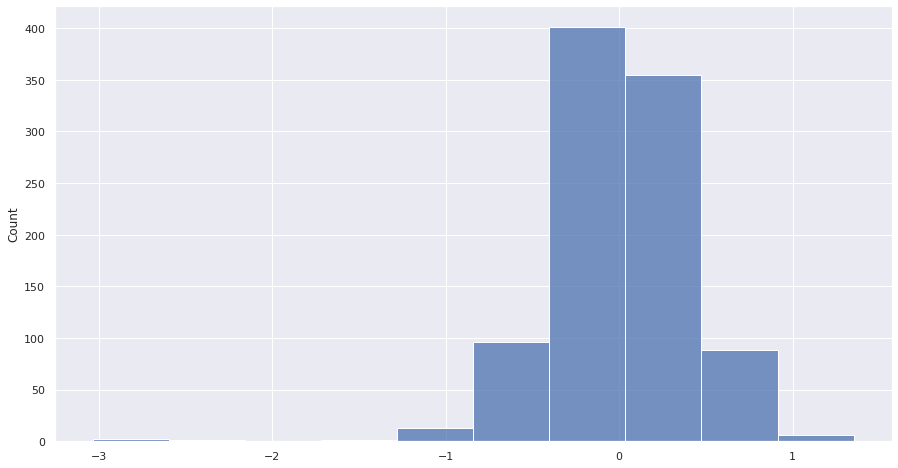

In [124]:
# Residuales
sns.histplot(ml_results.resid, bins=10)

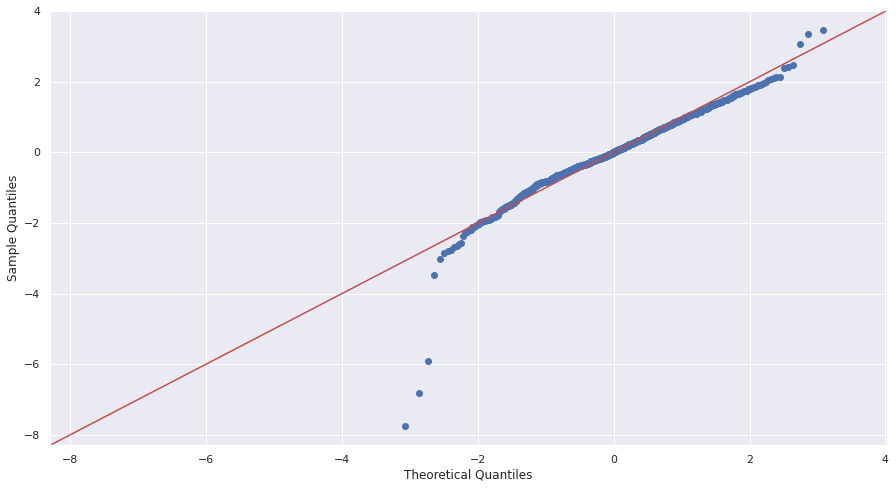

In [125]:
def grafico_qqplot():
    fig = sm.qqplot(lm_resid_stand,line='45')
    plt.show()

grafico_qqplot()

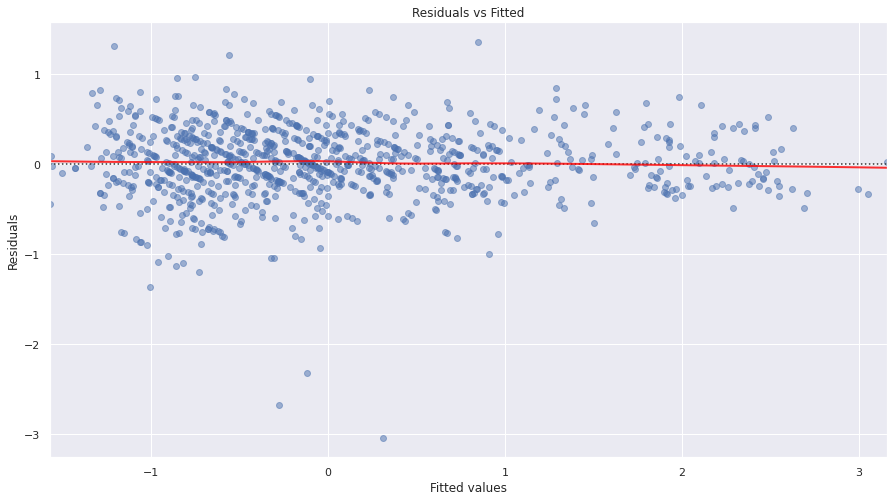

In [126]:
def residuales_vs_ajustados():
    plot = sns.residplot(x=fitted_values, y=residuals, lowess=True,
                         scatter_kws={'alpha': 0.5},
                         line_kws={'color': 'red', 'lw': 2, 'alpha': 0.8})

    # Titel and labels
    plot.set_title('Residuals vs Fitted')
    plot.set_xlabel('Fitted values')
    plot.set_ylabel('Residuals')
residuales_vs_ajustados()